In [ ]:
import torch
height = width = 16

height_gap = 2 / (height - 1)
width_gap = 2 / (width - 1)
height, width = torch.meshgrid([torch.range(-1, 1, height_gap), torch.Tensor(1)])

print(torch.range(-1, 1, height_gap))
print(height)

print(width)

lr_identity = torch.stack([width, height])


print(lr_identity.shape)

In [ ]:
a = {}
a['b'] = 2
a['c'] = 10

for k,v in a.items():
    print(k,v)

In [ ]:
a = [1,2,3,4]
def func(a):
    yield a[0], a[1], a[2], a[3]
    
for i in func(a):
    print(i)

In [ ]:
a = [1,2,3,4]
print(set(a))
def func(a):
    yield a[0]
    for i in range(len(a[1:])):
        yield a[i]
    
for i in func(a):
    print(i)

In [ ]:
a = True
b = True

a and b


import random
a = random.random()
print(a < 0.5)

b = b and random.random() < 0.5

In [ ]:
import torch
idx_data = 0
a = torch.rand([5,2,7])
print(a)
b, epoch_idx = a.max(0)
best, frame_idx = b.max(1)
print(epoch_idx)
print(best)
print(frame_idx)


best_frame_idx = frame_idx[idx_data]
print(best_frame_idx)
best_epoch_idx = epoch_idx[idx_data, frame_idx[idx_data]]
print(best_epoch_idx)

print(a[best_epoch_idx, idx_data, best_frame_idx])

In [ ]:
a = '10'

try:
    print("frame" + str(a))
except:
    raise TypeError("a should be int type")

In [ ]:
import torch
a = torch.rand([5,2,7])

print(a.shape[0])

In [ ]:
from tqdm import tqdm
import numpy as np
from time import sleep
for idx, i in enumerate(tqdm(np.arange(100))):
    print(idx)
    sleep(0.01)

In [ ]:
import torch

a = torch.tensor([3,4,5])

print(a)

print("a is {}".format(a))



In [ ]:
import numpy as np
import os

TAG_FLOAT = 202021.25
import torch.nn as nn
def read_flow(file):

    assert type(file) is str, "file is not str %r" % str(file)
    assert os.path.isfile(file) is True, "file does not exist %r" % str(file)
    assert file[-4:] == '.flo', "file ending is not .flo %r" % file[-4:]
    f = open(file,'rb')
    flo_number = np.fromfile(f, np.float32, count=1)[0]
    assert flo_number == TAG_FLOAT, 'Flow number %r incorrect. Invalid .flo file' % flo_number
    w = np.fromfile(f, np.int32, count=1)
    h = np.fromfile(f, np.int32, count=1)
    data = np.fromfile(f, np.float32, count=2*w[0]*h[0])
    #if error try: data = np.fromfile(f, np.float32, count=2*w*h)
    # Reshape data into 3D array (columns, rows, bands)
    flow = np.resize(data, (int(h), int(w), 2))
    f.close()

    return flow

def warp(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow.
    Code heavily inspired by
    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow
    """
    B, C, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
    yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
    xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
    yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
    grid = torch.cat((xx, yy), 1).float()
    #print(grid)
    grid = grid
    vgrid = grid + flo

    # scale grid to [-1,1]
    vgrid[:, 0, :, :] = 2.0*vgrid[:, 0, :, :]/max(W-1, 1)-1.0
    vgrid[:, 1, :, :] = 2.0*vgrid[:, 1, :, :]/max(H-1, 1)-1.0
    vgrid = vgrid.permute(0, 2, 3, 1)
    output = nn.functional.grid_sample(x, vgrid)
    # Define a first mask containing pixels that wasn't properly interpolated
    mask = torch.autograd.Variable(torch.ones(x.size()))
    mask = nn.functional.grid_sample(mask, vgrid)
    mask[mask < 0.9999] = 0
    mask[mask > 0] = 1

    return output, mask


filename = "/home/lrh/git/blind-denoising/tvl1flow/of/tvl1_target.flo"

of = read_flow(filename)
print(of.max())
print(of.min())

print(of.shape)

of = torch.tensor(of).unsqueeze(0).permute(0,3,1,2)

image_path = "/home/lrh/git/blind-denoising/tvl1flow/image/target/im3.png"
import imageio
import torch
image_np = cv2.imread(image_path)
image_tensor = torch.tensor(image_np).type(torch.FloatTensor).unsqueeze(0).permute(0,3,1,2)
print(image_tensor.shape)

o, m = warp(image_tensor, -of)

from matplotlib import pyplot as plt

target_path = "/home/lrh/git/blind-denoising/tvl1flow/image/target/im4.png"
image_target = cv2.imread(target_path)


plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(image_np)

plt.subplot(222)
plt.imshow(image_target)

plt.subplot(223)
plt.imshow(o[0].permute(1,2,0).numpy() / 255.0)

plt.show()

In [ ]:
import cv2
import numpy as np
from imageio import imread
img_file = '/home/lrh/git/blind-denoising/tvl1flow/image/target/im3.png'
img2_file = '/home/lrh/git/blind-denoising/tvl1flow/image/target/im4.png'

prev_frame =  cv2.imread(img_file)
next_frame = cv2.imread(img2_file)

flow_file = "/home/lrh/git/blind-denoising/tvl1flow/of/tvl1_target.flo"
flow = read_flow(flow_file)

def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = - flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

im2w = warp_flow(prev_frame, flow)


plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(prev_frame / 255.0)

plt.subplot(222)
plt.imshow(next_frame/255.0)

plt.subplot(223)
plt.imshow(im2w/255.0)

plt.show()

In [ ]:
data_path = '/store/dataset/vdenoising/vimeo/input1/v1/frame_017_noisy.png'


from PIL import Image
import numpy as np
img_pil = Image.open(data_path)
print(img_pil)
img = np.array(img_pil)
print(img.shape)
img = img[:,:,::-1]
print(img.shape)
from matplotlib import pyplot as plt
plt.imshow(img)
plt.show()

from skimage import filters
gaussian_img = filters.gaussian(img, sigma=1.5)

plt.imshow(gaussian_img)
plt.show()


#median_img = filters.median(img, np.ones((3, 3)))
#plt.imshow(median_img)
#plt.show()

In [ ]:
a = np.array([1,2,3])

a[::-1]

import cv2
img = cv2.imread(data_path)
plt.imshow(img)
plt.show()


blur = cv2.medianBlur(img,5)
plt.imshow(blur)
plt.show()


In [ ]:
import math
import numbers
import torch
from torch import nn
from torch.nn import functional as F

class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size=3, sigma=1.5, padding=1, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        self.padding = padding

        # print(kernel_size, sigma)
        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )

        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2

            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)


        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))
        #print(kernel.shape)
        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, padding=self.padding, groups=self.groups)

smoothing = GaussianSmoothing(2, 5, 1.5, padding=2, dim=2)
input = torch.rand(3, 2, 2, 100, 100)

f, b, c, h, w = input.size()
print(input.shape)

input = input.view(f*b, c, h, w)
print(input.shape)
#input = F.pad(input, (2, 2, 2, 2), mode='reflect')
output = smoothing(input)

len(output.chunk(2, dim=2))

t1, t2 = output.chunk(2, dim=2)

print(t1.shape)
print(t2.shape)

#output = output.view(f, b, c, h, w)
#print(output.shape)

In [ ]:
img = cv2.imread(data_path) / 255.0
plt.imshow(img)
plt.show()

import torch
img_tensor = torch.tensor(img).permute([2,0,1]).unsqueeze(0).type(torch.FloatTensor)

smoothing = GaussianSmoothing(3, 7, 2, padding=2, dim=2)
s_img_tensor = smoothing(img_tensor)

s_img = s_img_tensor.squeeze().permute(1,2,0)
plt.imshow(s_img)
plt.show()

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple


class MedianPool2d(nn.Module):
    """ Median pool (usable as median filter when stride=1) module.
    
    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=3, stride=1, padding=1, same=False):
        super(MedianPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding
    
    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd, 
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        return x

    
img = cv2.imread(data_path) / 255.0
plt.imshow(img)
plt.show()

import torch
img_tensor = torch.tensor(img).permute([2,0,1]).unsqueeze(0).type(torch.FloatTensor)

smoothing = MedianPool2d(kernel_size=5, padding=2)
s_img_tensor = smoothing(img_tensor)

print(s_img_tensor.shape)

s_img = s_img_tensor.squeeze().permute(1,2,0)
plt.imshow(s_img)
plt.show()

In [ ]:
import GPUtil
import time

while(True):
    try:
        DEVICE_ID_LIST = GPUtil.getFirstAvailable()
        break;
    except:
        time.sleep(1)
        print("hello world")

In [ ]:
import os
command = 'python main.py'
os.system(command)

In [ ]:
import glob
import os
import torch
import imageio

dataroot = "/store/dataset/vdenoising/vimeo/v1/"
def load_video_data(data_dir):
    noised_paths = glob.glob(os.path.join(data_dir, "noised", "*.png"))
    target_paths = glob.glob(os.path.join(data_dir, "target", "*.png"))
    noised_paths.sort()
    target_paths.sort()
    noised_images = []
    target_images = []
    for noised_path, target_path in zip(noised_paths, target_paths):
        noised_images.append(torch.tensor(imageio.imread(noised_path)))
        target_images.append(torch.tensor(imageio.imread(target_path)))

    ##frames, batch, CHW
    noised_images_torch = torch.stack(noised_images, dim=0).unsqueeze(1).permute(0,1,4,2,3)
    target_images_torch = torch.stack(target_images, dim=0).unsqueeze(1).permute(0,1,4,2,3)

    return noised_images_torch.type(torch.FloatTensor), target_images_torch.type(torch.FloatTensor)


#dirdata = '/home/lrh/git/data/v2'
dirdata = '/store/dataset/vdenoising/vimeo/v1/'
noise_input, target = load_video_data(dirdata)

print(noise_input.shape)

In [ ]:
## load_video_data
    # Return a generator for generating sequence of video frames
    # Indefinite length according to a file recording the pivot frame point
import os
pointpath = os.path.join(dataroot, 'point.txt')
f = open(pointpath)
points = [int(line) for line in f.readlines()]


from matplotlib import pyplot as plt

prepoint = 0
for point in points:
    print("frame index:", prepoint, point)
    img = noise_input[point - 1]

    img = img[0].permute(1,2,0).numpy() / 255.0
    img = img[:,:,::-1]

    plt.subplot(121)
    plt.imshow(img)
    
    
    img = noise_input[prepoint]

    img = img[0].permute(1,2,0).numpy() / 255.0
    img = img[:,:,::-1]
    plt.subplot(122)
    plt.imshow(img)
    plt.show()
    
    prepoint = point

In [ ]:
img = noise_input[10]

img = img[0].permute(1,2,0).numpy() / 255.0
img = img[:,:,::-1]

plt.imshow(img)

In [ ]:
import glob
import os
import torch
import imageio

dataroot = "/store/dataset/vdenoising/vimeo/v1/"

def load_video_data(data_dir, points = None):
    prepoint = 0
    if points is None:
        pointpath = os.path.join(data_dir, 'point.txt')
        f = open(pointpath)
        points = [int(line) for line in f.readlines()]
        
    noised_paths = glob.glob(os.path.join(data_dir, "noised", "*.png"))
    target_paths = glob.glob(os.path.join(data_dir, "target", "*.png"))
    noised_paths.sort()
    target_paths.sort()
    for point in points:
        n_paths = noised_paths[prepoint:point-1]
        t_paths = target_paths[prepoint:point-1]
        noised_images = []
        target_images = []
        for noised_path, target_path in zip(n_paths, t_paths):
            noised_images.append(torch.tensor(imageio.imread(noised_path)))
            target_images.append(torch.tensor(imageio.imread(target_path)))
        ##frames, batch, CHW
        noised_images_torch = torch.stack(noised_images, dim=0).unsqueeze(1).permute(0,1,4,2,3).type(torch.FloatTensor)
        target_images_torch = torch.stack(target_images, dim=0).unsqueeze(1).permute(0,1,4,2,3).type(torch.FloatTensor)
        
        yield noised_images_torch, target_images_torch, [prepoint, point-1]
        
        prepoint = point


data_generator = load_video_data(dataroot)
for d in data_generator:
    print(d[0][0])

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np; np.random.seed(0)

Z = np.random.poisson(lam=6, size=(64,64))
x = np.mean(Z, axis=0)
y = np.mean(Z, axis=1)

fig, ax = plt.subplots()
ax.imshow(Z)

# create new axes on the right and on the top of the current axes.
divider = make_axes_locatable(ax)
axtop = divider.append_axes("top", size=0.4, pad=0.3, sharex=ax)
axright = divider.append_axes("right", size=0.4, pad=0.4, sharey=ax)
#plot to the new axes
axtop.plot(np.arange(len(x)), x, marker="o", ms=1, mfc="k", mec="k")
axright.plot(y, np.arange(len(y)), marker="o", ms=1, mfc="k", mec="k")
#adjust margins
axright.margins(y=0)
axtop.margins(x=0)
plt.tight_layout()
plt.show()

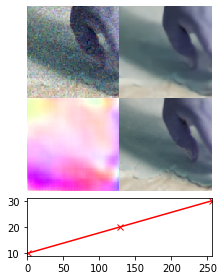

In [2]:
import imageio
import numpy as np
import os
def splice_image(imgs):
    assert len(imgs) == 4
    noised_img   = imgs[0]
    denoised_img = imgs[1]
    c1 = np.concatenate((noised_img, denoised_img), axis=1)

    flowmap    = imgs[2]
    target_img = imgs[3]
    c2 = np.concatenate((flowmap, target_img), axis = 1)

    c3 = np.concatenate((c1, c2), axis = 0)
    return c3


length = 3

dataroot = '/home/lrh/git/FRVD-pytorch/experiment/frvdwof-v0.2/results-ToFlow/'
filenames = ['00010_0144_frame2_Noise.png','00010_0144_frame2_Est.png',\
            '00010_0144_frame2_flow.png','00010_0144_frame2_Target.png']
imgs = []
for filename in filenames:
    imgs.append(imageio.imread(os.path.join(dataroot, filename)))
c_img = splice_image(imgs)[:,:,::-1]


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#plt.rcParams['axes.xmargin'] = 0
fig, ax = plt.subplots()
ax.imshow(c_img)
ax.axis('off')

length = 3

axisxlength = c_img.shape[1]
#axisylength = c_img.shape[0]

axisx = np.linspace(1, axisxlength, length)

divider = make_axes_locatable(ax)
axbottom = divider.append_axes("bottom", size=0.8, pad=0.1, sharex=ax)
axbottom.plot(axisx, [10,20,30], color='red', marker="x")
axbottom.set_xticks(axisx, np.linspace(1, length, length))
#axbottom.set_xticklabels(np.linspace(1, length, length))
axbottom.margins(x=0)
plt.tight_layout()
plt.show()

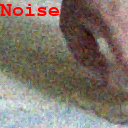

In [35]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import numpy as np

img = Image.open("/home/lrh/git/FRVD-pytorch/experiment/frvdwof-v0.2/results-ToFlow/00010_0144_frame2_Noise.png")

img = np.array(img) / 255.0

img = Image.fromarray((img * 255).astype(np.uint8))

draw = ImageDraw.Draw(img)
# font = ImageFont.truetype(<font-file>, <font-size>)
font = ImageFont.truetype("FreeMonoBold.ttf", 20)
# draw.text((x, y),"Sample Text",(r,g,b))
draw.text((0, 0),"Noise",'red', font=font)
img